# Load package

In [1]:
%cd ..

E:\Coding\Python\PlasmaChemistry


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import qgrid

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["font.size"] = 15

In [5]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, standard_Arr_constructor,
                           chemkin_Arr_2_rcnts_constructor,
                           chemkin_Arr_3_rcnts_constructor, eval_constructor,
                           reversed_reaction_constructor, alpha_constructor,
                           F_gamma_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [6]:
import yaml
yaml.add_constructor("!StandardArr", standard_Arr_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!ChemKinArr_2_rcnt", chemkin_Arr_2_rcnts_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!ChemKinArr_3_rcnt", chemkin_Arr_3_rcnts_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!rev", reversed_reaction_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!LT", LT_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!alpha", alpha_constructor, Loader=yaml.FullLoader)
yaml.add_constructor("!F_gamma", F_gamma_constructor, Loader=yaml.FullLoader)

# variables from widgets

`_species_list`

`_init_yaml_file_path`

`_vari_dict`

`rctn_all [dict, ...]`
 - _electron reactions_
 - _relaxation reactions_
 - _chemical reactions_
 - decom_recom reactions

`rctn_df [dataframe, ...]` 
- _species_
- _electron_
- _chemical_
- decom_recom
- _relaxation_

`rctn_instances [Reactions instances, ...]`
- _cros reactions_
- _coef reactions_

In [7]:
_species_list = [
    'E', 'H2(v0-14)', 'CO2(va-d)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O',
    'H2(all)', 'CO2(all)', 'CO(all)','O2(all)','H2O(all)',
    'C', 'H', 'O', 'OH'
]
_species_group = {"H2(all)": ["H2"] + [f"H2(v{_})" for _ in range(1,15)],
                 "CO2(all)": ["CO2"] + [f"CO2(v{_})" for _ in range(1,22)] + \
                 ["CO2(va)", "CO2(vb)", "CO2(vc)", "CO2(vd)"]}
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                  H2_vib_energy_in_K=H2_vib_energy_in_K,
                  CO_vib_energy_in_eV=CO_vib_energy_in_eV,
                  CO_vib_energy_in_K=CO_vib_energy_in_K,
                  CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                  CO2_vib_energy_in_K=CO2_vib_energy_in_K)
# ---------------------------------------------------------------------------- #
rctn_all = {
    'global_abbr': None,
    'electron reactions': None,
    'relaxation reactions': None,
    'chemical reactions': None,
    'decom_recom reactions': None
}
with open(_init_yaml_file_path, 'r') as f:
    rctn_block = yaml.load(f, Loader=yaml.FullLoader)
rctn_all = rctn_block[-1]['The reactions considered']

global_abbr = rctn_all['global_abbr']

rctn_df = {
    'species': None,
    'electron': None,
    'chemical': None,
    'decom_recom': None,
    'relaxation': None
}
rctn_instances = {'cros reactions': None, 'coef reactions': None}

# widgets function
`yaml file` => `rctn_all` (dict inside)
            => `rctn_df` (dataframe insdie) 
            => `rctn_instances` (instances inside)
- `get_species_from_widgets`
- `get_rctn_df_from_widgets`
- `instance_dataframe`



In [12]:
def get_species_from_widgets(_event):
    with _widgets['output']:
        print('Get species from widgets ...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO2(va-d)':
            species.extend(['CO2(va)', 'CO2(vb)', 'CO2(vc)', 'CO2(vd)'])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(1, 11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    assert rctn_df['species'][0] == 'E'
    with _widgets['output']:
        print('DONE!')


def get_rctn_df_from_widgets(_event):
    with _widgets['output']:
        print('Get reaction dataframe from widgets ...', end=' ')
    rctn_df['electron'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['chemical'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['relaxation'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['decom_recom'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ------------------------------------------------------------------------ #
    #    rctn_df that is generated from the widgets and rctn_all.
    # ------------------------------------------------------------------------ #
    #   electron
    for _ in _widgets['electron'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        factor = 1
        rctn_df['electron'] = pd.concat([
            rctn_df['electron'],
            _cros_block.generate_crostn_dataframe(factor=factor)
        ],
                                        ignore_index=True,
                                        sort=False)

    # ------------------------------------------------------------------------ #
    #   relaxation
    for _ in _widgets['relaxation'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['relaxation'] = pd.concat(
            [rctn_df['relaxation'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #   chemical
    for _ in _widgets['chemical'].value:
        _df = rctn_all['chemical reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['chemical'] = pd.concat(
            [rctn_df['chemical'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #    decom_recom
    for _ in _widgets['decom_recom'].value:
        _df = rctn_all['decom_recom reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['decom_recom'] = pd.concat(
            [rctn_df['decom_recom'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)
    with _widgets['output']:
        print('DONE!')


# ---------------------------------------------------------------------------- #
def rctn_all_dict_keys_to_formulas(_key):
    _formula = _key.replace('_to_', ' => ')
    _formula = _formula.replace('_', ' + ')
    return _formula


# ---------------------------------------------------------------------------- #
def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


# ---------------------------------------------------------------------------- #
def instance_dataframe(_):
    with _widgets['output']:
        print("Get instance from rctn_df ...", end=' ')
    # ------------------------------------------------------------------------ #
    reactant, product = from_rctn_df_to_cros_instance(rctn_df['electron'])

    rctn_instances['cros reactions'] = CrosReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        dH_e=rctn_df["electron"]["threshold_eV"],
        k_str=None)
    rctn_instances['cros reactions']._set_species_group(_species_group)
    # ------------------------------------------------------------------------ #
    reactant, product, kstr = pd.Series(), pd.Series(), pd.Series()
    for _key in ['relaxation', 'chemical', 'decom_recom']:
        _r, _p, _k = from_rctn_df_to_coef_instance(rctn_df[_key])
        reactant = pd.concat([reactant, _r], ignore_index=True, sort=False)
        product = pd.concat([product, _p], ignore_index=True, sort=False)
        kstr = pd.concat([kstr, _k], ignore_index=True, sort=False)

    rctn_instances['coef reactions'] = CoefReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=kstr)
    rctn_instances['coef reactions']._set_species_group(_species_group)
    rctn_instances['coef reactions'].compile_k_str()
    # ------------------------------------------------------------------------ #
    with _widgets['output']:
        print('DONE!')


def clean_output(_):
    _widgets['output'].clear_output()

# Set widgets and display widgets

In [13]:
# ---------------------------------------------------------------------------- #
_widgets = dict()
# ---------------------------------------------------------------------------- #
#   Set SelectMultiple widgets
# ---------------------------------------------------------------------------- #
for _, _option, _height in [
    ('species', _species_list, '400px'),
    ('electron', rctn_all['electron reactions'].keys(), '150px'),
    ('relaxation', rctn_all['relaxation reactions'].keys(), '150px'),
    ('chemical', rctn_all['chemical reactions'].keys(), '400px'),
    ('decom_recom', rctn_all['decom_recom reactions'].keys(), '400px')
]:
    if _ in ('chemical', 'decom_recom'):
        show_option = [(rctn_all_dict_keys_to_formulas(_o), _o)
                       for _o in _option]
    else:
        show_option = _option
    _widgets[_] = widgets.SelectMultiple(options=show_option,
                                         value=list(_option),
                                         layout=Layout(height=_height,
                                                       width='300px'))

# ---------------------------------------------------------------------------- #
#   Set FloatText widgets
# ---------------------------------------------------------------------------- #
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# ---------------------------------------------------------------------------- #
#   Set Buttons
# ---------------------------------------------------------------------------- #
_button = dict()
_button['load reactions'] = widgets.Button(description='rctn_all => rctn_df')
_button['instance rctn_df'] = widgets.Button(description='=> rctn_instances')
_button['clean output'] = widgets.Button(description='clean output')

# ---------------------------------------------------------------------------- #
_widgets['output'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%'
})


# ---------------------------------------------------------------------------- #
#   Widgets display
# ---------------------------------------------------------------------------- #
def _label(_str):
    return widgets.HTML(f'<b>{_str}</b>')


widgets.Text()
display(
    widgets.HBox([
        widgets.HTML('<b>Yaml File Path</b>'),
        widgets.Text(value=_init_yaml_file_path, disabled=True)
    ],
                 layout=Layout(border='solid 2px', width='80%')))
display(
    widgets.HBox(
        [
            #1
            widgets.VBox([_label('SPECIES'), _widgets['species']]),
            #2
            widgets.VBox([
                _label('ELECTRON REACTIONS'), _widgets['electron'],
                _label('RELAXATION REACTIONS'), _widgets['relaxation']
            ]),
            #3
            widgets.VBox([_label('CHEMICAL REACTIONS'), _widgets['chemical']]),
            #4
            widgets.VBox(
                [_label('DECOM_RECOM REACTIONS'), _widgets['decom_recom']])
        ],
        layout=Layout(width='80%', border='solid 2px')))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)",
                        width='80%',
                        border='solid 2px')))
display(
    widgets.VBox([
        _button['load reactions'], _button['instance rctn_df'],
        _button['clean output']
    ],
                 layout=Layout(border='solid 2px',
                               display='flex',
                               align_items='stretch',
                               width='30%')))
display(_widgets['output'])
# ---------------------------------------------------------------------------- #
#   Widgets events
# ---------------------------------------------------------------------------- #
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['load reactions'].on_click(get_species_from_widgets)
_button['instance rctn_df'].on_click(instance_dataframe)
_button['clean output'].on_click(clean_output)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

Output(layout=Layout(border='2px solid blue', width='80%'))

# Prepare rctn_instances

In [14]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
rctn_instances['cros reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron'],
    electron_energy_grid=eedf.energy_point)

E + H2 => E + H2(v1)
E + H2 => E + H2(v2)
E + H2 => E + H2(v3)
E + H2(v1) => E + H2(v2)
E + H2(v1) => E + H2(v3)
E + H2(v1) => E + H2(v4)
E + H2(v2) => E + H2(v3)
E + H2(v2) => E + H2(v4)
E + H2(v2) => E + H2(v5)
E + H2(v3) => E + H2(v4)
E + H2(v3) => E + H2(v5)
E + H2(v3) => E + H2(v6)
E + H2(v4) => E + H2(v5)
E + H2(v4) => E + H2(v6)
E + H2(v4) => E + H2(v7)
E + H2(v5) => E + H2(v6)
E + H2(v5) => E + H2(v7)
E + H2(v5) => E + H2(v8)
E + H2(v6) => E + H2(v7)
E + H2(v6) => E + H2(v8)
E + H2(v6) => E + H2(v9)
E + H2(v7) => E + H2(v8)
E + H2(v7) => E + H2(v9)
E + H2(v7) => E + H2(v10)
E + H2(v8) => E + H2(v9)
E + H2(v8) => E + H2(v10)
E + H2(v8) => E + H2(v11)
E + H2(v9) => E + H2(v10)
E + H2(v9) => E + H2(v11)
E + H2(v9) => E + H2(v12)
E + H2(v10) => E + H2(v11)
E + H2(v10) => E + H2(v12)
E + H2(v10) => E + H2(v13)
E + H2(v11) => E + H2(v12)
E + H2(v11) => E + H2(v13)
E + H2(v11) => E + H2(v14)
E + H2(v12) => E + H2(v13)
E + H2(v12) => E + H2(v14)
E + H2(v13) => E + H2(v14)
E + H2(v1) =>

E + CO2(vd) => E + CO2(v19)
E + CO2(vd) => E + CO2(v20)
E + CO2(vd) => E + CO2(v21)
E + CO2(v2) => E + CO2(vd)
E + CO2(v3) => E + CO2(vd)
E + CO2(v4) => E + CO2(vd)
E + CO2(v5) => E + CO2(vd)
E + CO2(v6) => E + CO2(vd)
E + CO2(v7) => E + CO2(vd)
E + CO2(v8) => E + CO2(vd)
E + CO2(v9) => E + CO2(vd)
E + CO2(v10) => E + CO2(vd)
E + CO2(v11) => E + CO2(vd)
E + CO2(v12) => E + CO2(vd)
E + CO2(v13) => E + CO2(vd)
E + CO2(v14) => E + CO2(vd)
E + CO2(v15) => E + CO2(vd)
E + CO2(v16) => E + CO2(vd)
E + CO2(v17) => E + CO2(vd)
E + CO2(v18) => E + CO2(vd)
E + CO2(v19) => E + CO2(vd)
E + CO2(v20) => E + CO2(vd)
E + CO2(v21) => E + CO2(vd)
E + CO2 => E + CO + O
E + CO2(va) => E + CO + O
E + CO2(vb) => E + CO + O
E + CO2(vc) => E + CO + O
E + CO2(vd) => E + CO + O
E + CO2(v1) => E + CO + O
E + CO2(v2) => E + CO + O
E + CO2(v3) => E + CO + O
E + CO2(v4) => E + CO + O
E + CO2(v5) => E + CO + O
E + CO2(v6) => E + CO + O
E + CO2(v7) => E + CO + O
E + CO2(v8) => E + CO + O
E + CO2(v9) => E + CO + O
E + 

# Tgas function

In [15]:
# ---------------------------------------------------------------------------- #
#   sharp down
#   slow down
# ---------------------------------------------------------------------------- #
def Tgas_func_sharp_down(t, time_end, Tgas_arc):
    if t > time_end:
        return 300
    else:
        return Tgas_arc


def Tgas_func_slow_down(t, time_end, time_cold, Tgas_arc):
    if t > time_end:
        return (Tgas_arc - 300) * math.exp(-(t - time_end)**2 / 2 /
                                           (time_cold - time_end)**2) + 300
    else:
        return Tgas_arc

# electron density function

In [16]:
def electron_density_func(t, time_end, _density):
    if t > time_end:
        return 0
    else:
        return _density

# dndt functions

In [17]:
_widgets['Tgas_K_0'] = widgets.Text(description='init Tgas_K:', value='3000')
_widgets['Te_eV_0'] = widgets.Text(description='init Te_eV:', value='1.5')
_widgets['ne_0'] = widgets.Text(description='init ne', value='1e20')
_widgets['time_span'] = widgets.Text(description='Time span:',
                                     value='0, 1e-1',
                                     layout=Layout(width='200px'))
_widgets['atol'] = widgets.Text(description='atol:',
                                value='1e12',
                                layout=Layout(width='200px'))
_widgets['rtol'] = widgets.Text(description='rtol:',
                                value='1e-2',
                                layout=Layout(width='200px'))
display(_widgets['Tgas_K_0'])
display(_widgets['Te_eV_0'])
display(_widgets['ne_0'])
display(_widgets['time_span'])
display(_widgets['atol'])
display(_widgets['rtol'])

Text(value='3000', description='init Tgas_K:')

Text(value='1.5', description='init Te_eV:')

Text(value='1e20', description='init ne')

Text(value='0, 1e-1', description='Time span:', layout=Layout(width='200px'))

Text(value='1e12', description='atol:', layout=Layout(width='200px'))

Text(value='1e-2', description='rtol:', layout=Layout(width='200px'))

In [18]:
Tgas_0 = float(_widgets['Tgas_K_0'].value)
Te_eV = float(_widgets['Te_eV_0'].value)
ne_0 = float(_widgets['ne_0'].value)
_atol = float(_widgets['atol'].value)
_rtol = float(_widgets['rtol'].value)
print(f"Tgas: {Tgas_0: .0f} K \nTe_eV: {Te_eV: .1f} eV \nne_0: {ne_0: .2e} m-3")
print(f"atol: {_atol:.0e} \nrtol: {_rtol:.0e}")

Tgas:  3000 K 
Te_eV:  2.0 eV 
ne_0:  1.00e+19 m-3
atol: 1e+12 
rtol: 1e-02


In [19]:
def dndt_cros(t, density_without_e, _electron_density):
    _instance = rctn_instances['cros reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_coef(t, density_without_e, _electron_density, Tgas_K):
    _instance = rctn_instances['coef reactions']
    _instance.set_rate_const(Tgas_K=Tgas_K)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_all(t, y):
    
    _e_density = electron_density_func(t, time_end, ne_0)
    
    # _Tgas_K = Tgas_func_sharp_down(t, 1e-3, Tgas_0)
    _Tgas_K = Tgas_func_slow_down(t, time_end, time_cold, Tgas_0)
    print(f"t = {t:.6e} s    Tgas_K: {_Tgas_K:.0f} K, H2: {y[0]:.1e} CO2: {y[15]:.1e}")
    dydt = dndt_cros(t, y, _e_density) + dndt_coef(t, y, _e_density, _Tgas_K)
    return dydt[1:]


def dndt_all_with_Tgas(t, y):
    pass

In [22]:
H2_percent_seq = [
    0.9999, 0.93333, 0.88889, 0.83333, 0.77778, 0.66667, 0.5, 0.33333, 0.23077,
    0.16667, 0.13043, 0.09091, 0.07407, 0.0566, 0.03, 0.01, 0
]
time_end_seq = [
    0.38564, 0.46339, 0.58923, 0.66704, 0.69614, 0.8726, 0.97919, 1.01216,
    1.05427, 1.14294, 1.06026, 1.11772, 1.13853, 1.17361, 1.26435, 1.30063,
    1.27632
]
#### ====================
# i_index = 6 for H2/CO2 = 1:1
i_index = 6
H2_percent = H2_percent_seq[i_index]
time_end = time_end_seq[i_index] * 1e-3
#
# H2_percent = 0.0002
# time_end = 1e-3
time_cold = time_end + 2e-2
# time_end = 1e-3

In [23]:
# ---------------------------------------------------------------------------- #
density_0 = rctn_instances['cros reactions'].get_initial_density(
    density_dict={
        'CO2': 2.4e24 * (1 - H2_percent),
        'H2': 2.4e24 * H2_percent,
        'E': ne_0,
        'CO2(all)':2.4e24 * (1 - H2_percent),
        'H2(all)': 2.4e24 * H2_percent,
    })
density_without_e_0 = density_0[1:]
normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=Te_eV)

# Start evolution

In [24]:
sol = solve_ivp(
    dndt_all,
    [float(_.strip()) for _ in _widgets['time_span'].value.split(',')],
    density_without_e_0,
    method='BDF',
    atol=float(_widgets['atol'].value),
    rtol=float(_widgets['rtol'].value))
print("Solve Done!")

t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 1.751221e-20 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.6e+11
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 0.0e+00
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 

t = 7.873806e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.7e+21
t = 7.873806e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.7e+21
t = 9.361086e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+22
t = 9.361086e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+22
t = 1.084837e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+22
t = 1.084837e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+22
t = 1.233565e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.4e+22
t = 1.233565e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.4e+22
t = 1.549176e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.9e+22
t = 1.549176e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.9e+22
t = 1.864788e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.3e+22
t = 1.864788e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.3e+22
t = 2.180399e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.7e+22
t = 2.180399e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.7e+22
t = 2.496011e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 3.1e+22
t = 2.496011e-09 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 

t = 1.653996e-07 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.0e+23
t = 1.653996e-07 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.0e+23
t = 1.912999e-07 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.0e+23
t = 1.912999e-07 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 2.0e+23
t = 2.172003e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 2.172003e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 2.665078e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 2.665078e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 3.158153e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 3.158153e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 3.651227e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 3.651227e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 4.144302e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 4.144302e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 4.637377e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 2.0e+23
t = 4.637377e-07 s    Tgas_K: 3000 K, H2: 1.1e+24 CO2: 

t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 1.4e+23
t = 2.586058e-06 s    Tgas_K: 3000 K, H2: 7.2e+23 CO2: 

t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 8.0e+22
t = 4.526413e-06 s    Tgas_K: 3000 K, H2: 4.4e+23 CO2: 

t = 9.945428e-06 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 3.1e+22
t = 1.063535e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.063535e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.063535e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.063535e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.040767e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 3.0e+22
t = 1.040767e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 3.0e+22
t = 1.086991e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.086991e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.086991e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.9e+22
t = 1.133215e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.8e+22
t = 1.133215e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 2.8e+22
t = 1.179439e-05 s    Tgas_K: 3000 K, H2: 1.8e+23 CO2: 2.7e+22
t = 1.179439e-05 s    Tgas_K: 3000 K, H2: 1.8e+23 CO2: 2.7e+22
t = 1.225663e-05 s    Tgas_K: 3000 K, H2: 1.8e+23 CO2: 2.6e+22
t = 1.225663e-05 s    Tgas_K: 3000 K, H2: 1.8e+23 CO2: 

t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 1.9e+22
t = 2.794083e-05 s    Tgas_K: 3000 K, H2: 1.6e+23 CO2: 

t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 1.6e+22
t = 7.580919e-05 s    Tgas_K: 3000 K, H2: 1.9e+23 CO2: 

t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+22
t = 1.801516e-04 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 

t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 7.5e+21
t = 4.005069e-04 s    Tgas_K: 3000 K, H2: 3.1e+23 CO2: 

t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.528772e-04 s    Tgas_K: 3000 K, H2: 3.4e+23 CO2: 

t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.794234e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.3e+21
t = 9.769482e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.769482e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.777913e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.792002e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.0e+21
t = 9.791995e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 9.824708e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.5e+21
t = 9.826136e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.5e+21
t = 9.826136e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.5e+21
t = 9.828252e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.828252e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.827798e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.827798e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.829459e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.829459e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.831121e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.831121e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.832782e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.832782e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.6e+21
t = 9.834444e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.7e+21
t = 9.834444e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 5.7e+21
t = 9.836610e-04 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.004479e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.0e+22
t = 1.010332e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.2e+22
t = 1.010332e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 1.136916e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.7e+22
t = 1.136916e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.7e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 1.8e+22
t = 1.223676e-03 s    Tgas_K: 3000 K, H2: 3.5e+23 CO2: 

t = 1.447428e-03 s    Tgas_K: 2999 K, H2: 3.3e+23 CO2: 2.0e+22
t = 1.584421e-03 s    Tgas_K: 2999 K, H2: 3.2e+23 CO2: 2.0e+22
t = 1.584421e-03 s    Tgas_K: 2999 K, H2: 3.3e+23 CO2: 2.1e+22
t = 1.721413e-03 s    Tgas_K: 2998 K, H2: 3.2e+23 CO2: 2.1e+22
t = 1.721413e-03 s    Tgas_K: 2998 K, H2: 3.2e+23 CO2: 2.1e+22
t = 1.721413e-03 s    Tgas_K: 2998 K, H2: 3.2e+23 CO2: 2.1e+22
t = 1.960263e-03 s    Tgas_K: 2997 K, H2: 3.1e+23 CO2: 2.2e+22
t = 1.960263e-03 s    Tgas_K: 2997 K, H2: 3.1e+23 CO2: 2.2e+22
t = 1.960263e-03 s    Tgas_K: 2997 K, H2: 3.1e+23 CO2: 2.2e+22
t = 2.199114e-03 s    Tgas_K: 2995 K, H2: 3.1e+23 CO2: 2.2e+22
t = 2.199114e-03 s    Tgas_K: 2995 K, H2: 3.1e+23 CO2: 2.2e+22
t = 2.437964e-03 s    Tgas_K: 2993 K, H2: 3.0e+23 CO2: 2.3e+22
t = 2.437964e-03 s    Tgas_K: 2993 K, H2: 3.0e+23 CO2: 2.3e+22
t = 2.437964e-03 s    Tgas_K: 2993 K, H2: 3.0e+23 CO2: 2.3e+22
t = 2.437964e-03 s    Tgas_K: 2993 K, H2: 3.0e+23 CO2: 2.3e+22
t = 2.437964e-03 s    Tgas_K: 2993 K, H2: 3.0e+23 CO2: 

t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 2.5e+22
t = 4.899845e-03 s    Tgas_K: 2949 K, H2: 2.8e+23 CO2: 

t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 3.1e+22
t = 1.552816e-02 s    Tgas_K: 2372 K, H2: 2.2e+23 CO2: 

t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 3.3e+22
t = 2.010512e-02 s    Tgas_K: 2009 K, H2: 2.3e+23 CO2: 

t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 3.6e+22
t = 2.554162e-02 s    Tgas_K: 1570 K, H2: 2.5e+23 CO2: 

t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 4.5e+22
t = 3.174965e-02 s    Tgas_K: 1127 K, H2: 2.8e+23 CO2: 

t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.690448e-02 s    Tgas_K: 838 K, H2: 3.0e+23 CO2: 5.0e+22
t = 3.69

t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.174467e-02 s    Tgas_K: 638 K, H2: 3.0e+23 CO2: 4.6e+22
t = 4.17

t = 4.645845e-02 s    Tgas_K: 503 K, H2: 3.0e+23 CO2: 3.7e+22
t = 4.645845e-02 s    Tgas_K: 503 K, H2: 3.0e+23 CO2: 3.7e+22
t = 4.645845e-02 s    Tgas_K: 503 K, H2: 3.0e+23 CO2: 3.7e+22
t = 4.645845e-02 s    Tgas_K: 503 K, H2: 3.0e+23 CO2: 3.7e+22
t = 4.688093e-02 s    Tgas_K: 494 K, H2: 3.0e+23 CO2: 3.6e+22
t = 4.688093e-02 s    Tgas_K: 494 K, H2: 3.0e+23 CO2: 3.6e+22
t = 4.744366e-02 s    Tgas_K: 482 K, H2: 3.0e+23 CO2: 3.4e+22
t = 4.744366e-02 s    Tgas_K: 482 K, H2: 3.0e+23 CO2: 3.4e+22
t = 4.800640e-02 s    Tgas_K: 470 K, H2: 3.0e+23 CO2: 3.3e+22
t = 4.800640e-02 s    Tgas_K: 470 K, H2: 3.0e+23 CO2: 3.3e+22
t = 4.800640e-02 s    Tgas_K: 470 K, H2: 3.0e+23 CO2: 3.3e+22
t = 4.856913e-02 s    Tgas_K: 459 K, H2: 3.0e+23 CO2: 3.2e+22
t = 4.856913e-02 s    Tgas_K: 459 K, H2: 3.0e+23 CO2: 3.2e+22
t = 4.856913e-02 s    Tgas_K: 459 K, H2: 3.0e+23 CO2: 3.2e+22
t = 4.913186e-02 s    Tgas_K: 449 K, H2: 3.0e+23 CO2: 3.1e+22
t = 4.913186e-02 s    Tgas_K: 449 K, H2: 3.0e+23 CO2: 3.1e+22
t = 4.91

t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.088687e-02 s    Tgas_K: 330 K, H2: 3.0e+23 CO2: 1.6e+22
t = 6.08

t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 7.880784e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 8.176615e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 8.176615e-02 s    Tgas_K: 301 K, H2: 3.0e+23 CO2: 1.2e+22
t = 8.758544e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 8.758544e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 9.340472e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 9.340472e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 9.922401e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 9.922401e-02 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 1.000000e-01 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
t = 1.000000e-01 s    Tgas_K: 300 K, H2: 3.0e+23 CO2: 1.2e+22
Solve Do

# Plot results

fig, ax = plt.subplots()
_Tgas = [Tgas_func_slow_down(_, 1e-3, 2e-3, Tgas_0) for _ in sol.t]
_e_density = [electron_density_func(_, 1e-3, ne_0) for _ in sol.t]
ax.semilogx(sol.t, _Tgas, marker='.')
ax_right = ax.twinx()
ax_right.plot(sol.t, _e_density, marker='.', color='red')

In [25]:
_CO2_group = ['CO2'] + [f"CO2(v{_})" for _ in range(1, 22)]
_CO2_group_all = _CO2_group + ['CO2(va)', 'CO2(vb)', 'CO2(vc)', 'CO2(vd)']
_H2_group = ['H2'] + [f"H2(v{_})" for _ in range(1, 15)]
_CO_group = ['CO'] + [f"CO(v{_})" for _ in range(1, 11)]
density_result = np.vstack(
    [[electron_density_func(_, time_end, ne_0) for _ in sol.t], sol.y])
density_result_df = pd.DataFrame(
    density_result, index=rctn_instances['cros reactions'].species)
densities = dict()

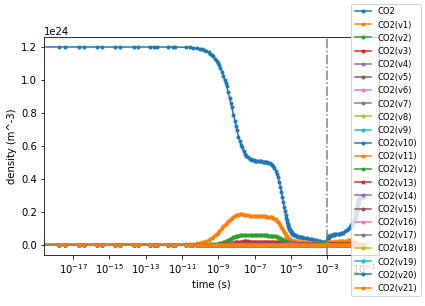

In [26]:
# ---------------------------------------------------------------------------- #
#   Plot CO2 vdf
# ---------------------------------------------------------------------------- #
%matplotlib inline
fig, ax = plt.subplots()
for _ in ['CO2'] + [f"CO2(v{_})" for _ in range(1,22)]:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    elif _ == 'CO_total':
        densities[_] = density_result_df.loc[_CO_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _].transpose()
    ax.semilogx(sol.t, densities[_], marker='.', label=_)
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
ax.axvline(time_end, color='gray', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')

In [27]:
density_result_df.loc[_CO2_group_all,:]

,0,1,2,3,4,5,6,7,8,9,...,325,326,327,328,329,330,331,332,333,334
CO2,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.200000e+24,1.199997e+24,...,2.893339e+23,2.896845e+23,2.901354e+23,2.904084e+23,2.905707e+23,2.906652e+23,2.907483e+23,2.907737e+23,2.907808e+23,2.907813e+23
CO2(v1),0.000000e+00,1.993293e+14,3.986587e+14,2.391952e+15,4.385245e+15,2.431817e+16,4.425110e+16,2.435801e+17,4.429088e+17,2.436168e+18,...,9.594065e+18,8.969616e+18,8.208254e+18,7.769495e+18,7.516657e+18,7.372157e+18,7.246586e+18,7.208699e+18,7.198145e+18,7.197540e+18
CO2(v2),0.000000e+00,7.358551e+10,1.471711e+11,8.830326e+11,1.618901e+12,8.978158e+12,1.633807e+13,8.999496e+13,1.637176e+14,9.067167e+14,...,3.554643e+14,3.106239e+14,2.601557e+14,2.331793e+14,2.180372e+14,2.097235e+14,2.026308e+14,2.005151e+14,1.999273e+14,1.998934e+14
CO2(v3),0.000000e+00,4.481584e+10,8.963168e+10,5.377901e+11,9.859484e+11,5.467532e+12,9.949114e+12,5.476488e+13,9.958056e+13,5.477312e+14,...,1.485550e+10,1.213303e+10,9.270042e+09,7.893797e+09,7.111334e+09,6.710016e+09,6.373836e+09,6.274709e+09,6.247193e+09,6.245542e+09
CO2(v4),0.000000e+00,3.279849e+01,1.035159e+02,4.149737e+03,1.199709e+04,4.243896e+05,1.216898e+06,4.253373e+07,1.218618e+08,4.254166e+09,...,7.335549e+05,5.506894e+05,3.821353e+05,3.279791e+05,2.603261e+05,2.410399e+05,2.251836e+05,2.205756e+05,2.193088e+05,2.192295e+05
CO2(v5),0.000000e+00,8.318006e-02,2.625261e-01,1.052416e+01,3.042589e+01,1.076327e+03,3.086307e+03,1.079049e+05,3.091941e+05,1.082432e+07,...,6.022337e+01,3.299637e+01,2.156764e+01,2.406586e+01,1.070592e+01,9.729358e+00,8.941221e+00,8.714706e+00,8.654319e+00,8.650303e+00
CO2(v6),0.000000e+00,4.747325e-02,1.498312e-01,6.006420e+00,1.736486e+01,6.142714e+02,1.761366e+03,6.156484e+04,1.763878e+05,6.158167e+06,...,2.317165e-02,3.681908e-03,1.894274e-03,-1.209727e-03,4.924405e-04,2.666228e-04,-2.230228e-04,-9.999276e-04,4.215362e-04,3.858022e-04
CO2(v7),0.000000e+00,2.667810e-02,8.419922e-02,3.375372e+00,9.758365e+00,3.451963e+02,9.898186e+02,3.459702e+04,9.912301e+04,3.460656e+06,...,-1.649766e-03,2.226214e-04,1.836682e-04,-3.460643e-03,6.771500e-06,-4.202434e-05,-4.235674e-04,-6.982045e-04,2.709744e-06,-6.671552e-07
CO2(v8),0.000000e+00,1.535939e-02,4.847606e-02,1.943305e+00,5.618189e+00,1.987401e+02,5.698688e+02,1.991856e+04,5.706813e+04,1.992401e+06,...,-2.215269e-03,-8.089037e-04,4.392318e-04,-7.699250e-04,5.059373e-06,-8.262009e-05,-6.323406e-04,-1.336027e-03,-2.252823e-04,-1.783899e-06
CO2(v9),0.000000e+00,8.800048e-03,2.777399e-02,1.113402e+00,3.218899e+00,1.138666e+02,3.265020e+02,1.141219e+04,3.269675e+04,1.141530e+06,...,-1.615950e-03,-7.228184e-04,1.011489e-04,-8.158276e-04,4.838009e-06,-1.594886e-05,-2.148510e-04,-5.554141e-04,-3.928498e-05,-2.785267e-06


In [28]:
CO2_normal_vdf = (density_result_df.loc[_CO2_group_all,:].values/density_result_df.loc['CO2',:].values).transpose()
CO2_normal_vdf.shape
sol.t.transpose().shape

(335,)

In [29]:
np.savetxt('_output/CO2_vdf.txt', np.vstack((sol.t,CO2_normal_vdf.transpose())).transpose())

In [30]:
for _ in sol.t:
#     print(_, end=' ')
    print(Tgas_func_slow_down(_, time_end, time_end+4e-3, Tgas_0))
#     print(electron_density_func(_, time_end, 1e20))

3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0
3000.0

## reaction info

In [31]:
print(H2_percent)
print(H2_percent/(1-H2_percent))
print("H O OH")
print(
    f"{density_result_df.loc['H'].max():.1e} {density_result_df.loc['O'].max():.1e} {density_result_df.loc['OH'].max():.1e} "
)
print(f"CO max: {density_result_df.loc[_CO_group, :].sum().values.max():.3e}")
print(f"CO output: {density_result_df.loc['CO'].values[-1]:.1e}")

0.5
1.0
H O OH
5.3e+23 2.2e+23 2.6e+23 
CO max: 1.171e+24
CO output: 9.0e+23


In [32]:
density_result_df.loc[_CO_group, :].sum().values[-1]

8.960553906839245e+23

In [33]:
density_result_df.loc[_CO_group, :].sum().values.max()

1.170603743837864e+24

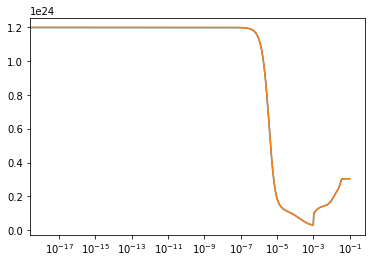

In [34]:
plt.semilogx(sol.t, density_result_df.loc['CO2(all)'])
plt.semilogx(sol.t, density_result_df.loc[_CO2_group_all].sum())

## show vdf

Output(layout=Layout(border='2px solid blue', height='350px', width='80%'))

FloatLogSlider(value=1.7512212202583954e-18, description='Time (s):', max=-1.0, min=-17.75665898888571, step=0…

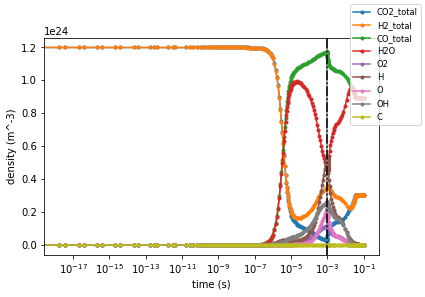

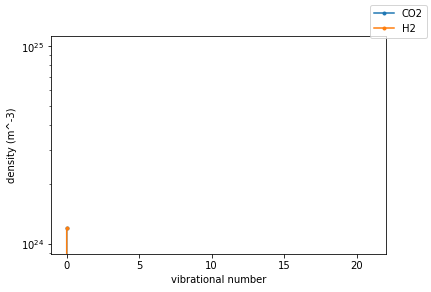

In [35]:
# _widgets['plot_vdf'] = widgets.FloatLogSlider(value=sol.t[1], min=sol.t[1], max=sol.t[-1],step=1)
_widgets['plot_vdf'] = widgets.FloatLogSlider(value=math.log10(sol.t[1]),
                                              min=math.log10(sol.t[1]),
                                              max=math.log10(sol.t[-1]),
                                              step=0.0001,
                                              description='Time (s):')

_widgets['output_rctn'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%',
    'height': '350px'
})

display(_widgets['output_rctn'])
display(_widgets['plot_vdf'])
_df_show_vdf = pd.Series(index=rctn_instances['cros reactions'].species)

_interp_result = interp1d(sol.t, density_result)


def get_CO2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_CO2_group].values


def get_H2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_H2_group].values

# ---------------------------------------------------------------------------- #
#   plot main molecule
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
output_evolution = [sol.t]
for _ in ['CO2_total', 'H2_total', 'CO_total', 'H2O', 'O2', 'H', 'O', 'OH', 'C']:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group_all, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    elif _ == 'CO_total':
        densities[_] = density_result_df.loc[_CO_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _][0]
    line_species, = ax.semilogx(sol.t, densities[_], marker='.', label=_)
    output_evolution.append(densities[_])
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
vline_time_end = ax.axvline(time_end, color='gray', linestyle='-')
vline = ax.axvline(time_end, color='black', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')
# ---------------------------------------------------------------------------- #
#   plot the vdf
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
line_CO2_vdf, = ax.semilogy(list(range(22)), get_CO2_vdf_at_time(0), marker='.',label='CO2')
line_H2_vdf, = ax.semilogy(list(range(15)), get_H2_vdf_at_time(0), marker='.', label='H2')
# ax.set_title('CO2 density vs. v')
ax.set_xlabel('vibrational number')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right')
# ax.set_title('H2 density vs. v')
# ax.set_xlabel('H2_vdf')
# ax.set_ylabel('density')


def plot_CO2_vdf(change):
    _t = change['new']
    _ydata = get_CO2_vdf_at_time(_t)
    line_CO2_vdf.set_ydata(_ydata)
    ax.set_ylim(_ydata.max()*1e-30, _ydata.max())


def plot_H2_vdf(change):
    _t = change['new']
    line_H2_vdf.set_ydata(get_H2_vdf_at_time(_t))

def CO2_consume_regexp_match(_str):
    rcnt, prdt = _str.split('=>')
    if rcnt.count('CO2') > prdt.count('CO2'):
        return True
    else:
        return False

def CO2_produce_regexp_match(_str):
    rcnt, prdt = _str.split('=>')
    if rcnt.count('CO2') < prdt.count('CO2'):
        return True
    else:
        return False
    
def show_top_reactions(change):
    # _formula_regexp = "(.*\s+)?O\s+.*=>.*"
    regexp_match = CO2_produce_regexp_match
    _t = change['new']
    _Tgas = Tgas_func_slow_down(_t, time_end, time_cold, Tgas_0)
    rctn_instances['coef reactions'].set_rate_const(Tgas_K=_Tgas)
    rctn_instances['coef reactions'].set_rate(density=_interp_result(_t))
    rctn_instances['cros reactions'].set_rate(density=_interp_result(_t))
    _df_coef = rctn_instances['coef reactions'].view_rate_const_and_rate()
    _df_cros = rctn_instances['cros reactions'].view_rate_const_and_rate()
    # _df_coef = _df_coef[_df_coef['formula'].map(CO2_consume_regexp_match)]
    # _df = _df[_df['formula'].str.match(_formula_regexp)]
    
    # _df_cros = _df_cros[_df_cros['formula'].map(CO2_consume_regexp_match)]
    _df = pd.concat([_df_cros, _df_coef], ignore_index=True)
    
    _df = _df[_df['formula'].map(regexp_match)]
    _df = _df.sort_values(by='rate', ascending=False)
    _widgets['output_rctn'].clear_output()
    vline.set_xdata(_t)
    with _widgets['output_rctn']:
        print(_df.head(n=20))
    
_widgets['plot_vdf'].observe(plot_CO2_vdf, names='value')
_widgets['plot_vdf'].observe(plot_H2_vdf, names='value')
_widgets['plot_vdf'].observe(show_top_reactions, names='value')

In [80]:
# _formula_regexp = "(.*\s+)?O\s+.*=>.*"
# regexp_match = CO2_produce_regexp_match
_rate_consume_total = []
_rate_produce_total = []
_electron_energy_loss = []
for i, _t in enumerate(sol.t):
    print(i)
    _Tgas = Tgas_func_slow_down(_t, time_end, time_cold, Tgas_0)
    rctn_instances['coef reactions'].set_rate_const(Tgas_K=_Tgas)
    rctn_instances['coef reactions'].set_rate(density=_interp_result(_t))
    rctn_instances['cros reactions'].set_rate(density=_interp_result(_t))
    _df_coef = rctn_instances['coef reactions'].view_rate_const_and_rate()
    
    _df_cros = rctn_instances['cros reactions'].view_rate_const_and_rate()
    _electron_energy_loss.append((rctn_instances["cros reactions"].dH_e * rctn_instances["cros reactions"].rate).tolist())
    # _df_cros["dH_e_rate_const"] = rctn_instances["cros reactions"].get_dH_e()
    # _df_coef = _df_coef[_df_coef['formula'].map(CO2_consume_regexp_match)]
    # _df = _df[_df['formula'].str.match(_formula_regexp)]

    # _df_cros = _df_cros[_df_cros['formula'].map(CO2_consume_regexp_match)]
    _df = pd.concat([_df_cros, _df_coef], ignore_index=True)

    _rate_consume = [
        _df[_df['formula'].str.match(r"E \+ CO2.* => E \+ CO \+ O")]
        ['rate'].sum(), _df[_df['formula'].str.match(
            r"CO2.* \+ \S* => CO \+ O \S*")]['rate'].sum(),
        _df[_df['formula'].str.match(r"CO2.* \+ H => CO \+ OH")]['rate'].sum(),
        _df[_df['formula'].str.match(r"CO2.* \+ O => CO \+ O2")]['rate'].sum()
    ]
    _rate_produce = [_df[_df['formula'].str.match(r"CO \+ O .* => CO2.* \+ .*")]['rate'].sum(),
                     _df[_df['formula'].str.match(r"CO \+ OH => CO2.* \+ H")]['rate'].sum(),
                     _df[_df['formula'].str.match(r"CO \+ O2 => CO2.* \+ O")]['rate'].sum()
    ]
    _rate_consume_total.append(_rate_consume)
    _rate_produce_total.append(_rate_produce)

    # _df = _df[_df['formula'].map(regexp_match)]
_rate_consume_total = np.array(_rate_consume_total)
_rate_produce_total = np.array(_rate_produce_total)
_electron_energy_loss = np.array(_electron_energy_loss).transpose()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [111]:
_electron_energy_loss_vib_exc = _electron_energy_loss[0:78,:].sum(axis=0) + _electron_energy_loss[92:398,:].sum(axis=0) + \
_electron_energy_loss[424:478,:].sum(axis=0)
_electron_energy_loss_dis_exc = _electron_energy_loss.sum(axis=0)-_electron_energy_loss_vib_exc

In [117]:
for i, _ in enumerate(sol.t):
    print(_ ,end=' ')
    print(_electron_energy_loss_vib_exc[i], end=' ')
    print(_electron_energy_loss_dis_exc[i])

0.0 1.1308933170694524e+29 4.729387513306389e+28
1.7512212202584012e-18 1.1308933169448649e+29 4.729387513347375e+28
3.5024424405168024e-18 1.130893316820278e+29 4.729387513388356e+28
2.1014654643100814e-17 1.1308933155744035e+29 4.729387513798205e+28
3.8526866845684823e-17 1.1308933143285293e+29 4.729387514208052e+28
2.1364898887152493e-16 1.1308933018697882e+29 4.7293875183065e+28
3.8877111089736503e-16 1.1308932894110476e+29 4.729387522404953e+28
2.1399923311557663e-15 1.130893164823692e+29 4.729387563389451e+28
3.891213551414168e-15 1.1308930402363927e+29 4.729387604373925e+28
2.1403425753998186e-14 1.1308917943683416e+29 4.729388014216534e+28
3.89156379565822e-14 1.1308905485059155e+29 4.72938842405673e+28
1.6894874296212537e-13 1.1308812977989595e+29 4.729391467161625e+28
2.9898184796766854e-13 1.1308720474044688e+29 4.729394510132422e+28
4.290149529732117e-13 1.1308627973258174e+29 4.729397552967682e+28
1.7098936897087197e-12 1.1307716972545029e+29 4.7294275188556235e+28
2.99077

In [114]:
_electron_energy_loss_dis_exc.shape

(335,)

In [110]:
for i, _ in enumerate(rctn_instances["cros reactions"].product):
    if _.count("+") == 1:
        print(i,end=' ')
        print(_)

0 E + H2(v1)
1 E + H2(v2)
2 E + H2(v3)
3 E + H2(v2)
4 E + H2(v3)
5 E + H2(v4)
6 E + H2(v3)
7 E + H2(v4)
8 E + H2(v5)
9 E + H2(v4)
10 E + H2(v5)
11 E + H2(v6)
12 E + H2(v5)
13 E + H2(v6)
14 E + H2(v7)
15 E + H2(v6)
16 E + H2(v7)
17 E + H2(v8)
18 E + H2(v7)
19 E + H2(v8)
20 E + H2(v9)
21 E + H2(v8)
22 E + H2(v9)
23 E + H2(v10)
24 E + H2(v9)
25 E + H2(v10)
26 E + H2(v11)
27 E + H2(v10)
28 E + H2(v11)
29 E + H2(v12)
30 E + H2(v11)
31 E + H2(v12)
32 E + H2(v13)
33 E + H2(v12)
34 E + H2(v13)
35 E + H2(v14)
36 E + H2(v13)
37 E + H2(v14)
38 E + H2(v14)
39 E + H2
40 E + H2
41 E + H2(v1)
42 E + H2
43 E + H2(v1)
44 E + H2(v2)
45 E + H2(v1)
46 E + H2(v2)
47 E + H2(v3)
48 E + H2(v2)
49 E + H2(v3)
50 E + H2(v4)
51 E + H2(v3)
52 E + H2(v4)
53 E + H2(v5)
54 E + H2(v4)
55 E + H2(v5)
56 E + H2(v6)
57 E + H2(v5)
58 E + H2(v6)
59 E + H2(v7)
60 E + H2(v6)
61 E + H2(v7)
62 E + H2(v8)
63 E + H2(v7)
64 E + H2(v8)
65 E + H2(v9)
66 E + H2(v8)
67 E + H2(v9)
68 E + H2(v10)
69 E + H2(v9)
70 E + H2(v10)
71 E + H2(v

In [89]:
"+".count("+")

1

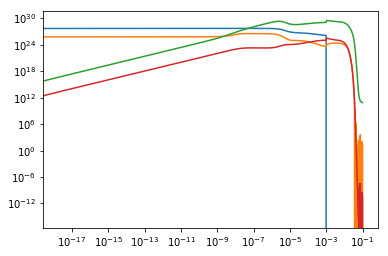

In [39]:
%matplotlib inline
fig, ax = plt.subplots()
ax.loglog(sol.t, _rate_consume_total)

In [40]:
from scipy.integrate import trapz

In [41]:
output_produce = trapz(_rate_produce_total.transpose(), x=sol.t)
for _ in output_produce:
    print(f"{_:.9e}")

5.924691317e+22
2.035884411e+27
1.950074919e+23


In [42]:
output_consume = trapz(_rate_consume_total.transpose(),x=sol.t)
for _ in output_consume:
    print(f"{_:.9e}")

2.305396444e+23
2.267844395e+22
2.036819513e+27
1.051974044e+23


In [43]:
print(f"{output_consume[0]:.9e}")
print(f"{output_consume[1]-output_produce[0]:.9e}")
print(f"{output_consume[2]-output_produce[1]:.9e}")
print(f"{output_consume[3]-output_produce[2]:.9e}")
print(f"{output_consume.sum()-output_produce.sum():.9e}")

2.305396444e+23
-3.656846922e+22
9.351024860e+23
-8.981008747e+22
1.039263574e+24


In [44]:
output_consume.sum()

2.03717792856706e+27

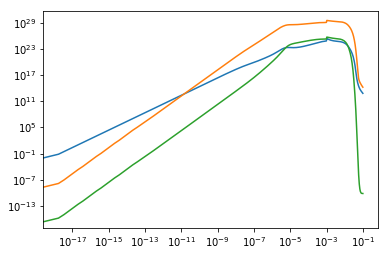

In [45]:
%matplotlib inline
fig, ax = plt.subplots()
ax.loglog(sol.t, _rate_produce_total)

In [48]:
_df[_df['formula'].str.match(r"CO2.* \+ \S* => CO \+ O \S*")]

,formula,rate_const,rate
2029,CO2 + CO2(all) => CO + O + CO2(all),1.091401e-87,9.646099e-41
2030,CO2(v1) + CO2(all) => CO + O + CO2(all),6.081925e-83,1.330534e-40
2031,CO2(v2) + CO2(all) => CO + O + CO2(all),3.016809e-78,1.832935e-40
2032,CO2(v3) + CO2(all) => CO + O + CO2(all),1.332002e-73,2.528576e-40
2033,CO2(v4) + CO2(all) => CO + O + CO2(all),5.234948e-69,3.488286e-40
2034,CO2(v5) + CO2(all) => CO + O + CO2(all),1.837275e-64,4.830659e-40
2035,CO2(v6) + CO2(all) => CO + O + CO2(all),5.721135e-60,6.708843e-40
2036,CO2(v7) + CO2(all) => CO + O + CO2(all),1.590906e-55,-3.226059e-38
2037,CO2(v8) + CO2(all) => CO + O + CO2(all),3.937833e-51,-2.135150e-33
2038,CO2(v9) + CO2(all) => CO + O + CO2(all),8.648009e-47,-7.321224e-29


In [49]:
_df[_df['formula'].str.match(r"CO2.* \+ H => CO \+ OH")]['rate'].sum()

73922344748.06023

In [50]:
_df[_df['formula'].str.match(r"CO2.* \+ O => CO \+ O2")]

,formula,rate_const,rate
1924,CO2 + O => CO + O2,1.257745e-57,1.042440e-21
1925,CO2(v1) + O => CO + O2,5.517307e-55,1.131888e-23
1926,CO2(v2) + O => CO + O2,2.268405e-52,1.292442e-25
1927,CO2(v3) + O => CO + O2,8.741241e-50,1.556092e-27
1928,CO2(v4) + O => CO + O2,3.157071e-47,1.972765e-29
1929,CO2(v5) + O => CO + O2,1.070623e-44,2.639731e-31
1930,CO2(v6) + O => CO + O2,3.396765e-42,3.735272e-33
1931,CO2(v7) + O => CO + O2,1.011895e-39,-1.924218e-33
1932,CO2(v8) + O => CO + O2,2.825297e-37,-1.436568e-30
1933,CO2(v9) + O => CO + O2,7.380232e-35,-5.859071e-28


In [51]:
_df[_df['formula'].str.match(r"E \+ CO2.* => E \+ CO \+ O")]

,formula,rate_const,rate
398,E + CO2 => E + CO + O,4.110031e-16,0.0
399,E + CO2(va) => E + CO + O,4.241394e-16,0.0
400,E + CO2(vb) => E + CO + O,4.379293e-16,0.0
401,E + CO2(vc) => E + CO + O,4.521913e-16,0.0
402,E + CO2(vd) => E + CO + O,4.659086e-16,0.0
403,E + CO2(v1) => E + CO + O,4.586266e-16,0.0
404,E + CO2(v2) => E + CO + O,5.106298e-16,0.0
405,E + CO2(v3) => E + CO + O,5.672505e-16,0.0
406,E + CO2(v4) => E + CO + O,6.286615e-16,0.0
407,E + CO2(v5) => E + CO + O,6.934422e-16,0.0


In [52]:
_df[_df['formula'].str.match(r"CO2.* \+ \S* => CO \+ O \S*")]['rate'].sum()

-0.3696356930026239

In [53]:
np.savetxt('output_evolution.dat', np.array(output_evolution).transpose())

In [54]:
np.savetxt('output_CO2_vdf.dat', np.array(line_CO2_vdf.get_data()).transpose())
np.savetxt('output_H2_vdf.dat', np.array(line_H2_vdf.get_data()).transpose())

In [ ]:
np.array(line_CO2_vdf.get_data()).transpose()

In [55]:
# ---------------------------------------------------------------------------- #
#   choose the time
# ---------------------------------------------------------------------------- #
t_chosen = 0.9e-3
# ---------------------------------------------------------------------------- #
_t_index_chosen = np.argmin(np.abs(sol.t - t_chosen))
rctn_instances['cros reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['cros reactions'].view_rate_const_and_rate().sort_values(
    by='rate', ascending=False)


def _match(x):
    if re.match('.*H2.*=>.*H [+] H|.*CO2.*=>.*CO [+] O', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

,formula,rate_const,rate
78,E + H2 => E + H + H,1.617226e-16,5.556696e+26
398,E + CO2 => E + CO + O,4.110031e-16,5.664997e+25
399,E + CO2(va) => E + CO + O,4.241394e-16,2.188402e+25
403,E + CO2(v1) => E + CO + O,4.586266e-16,1.766775e+25
400,E + CO2(vb) => E + CO + O,4.379293e-16,1.103354e+25
402,E + CO2(vd) => E + CO + O,4.659086e-16,1.053083e+25
401,E + CO2(vc) => E + CO + O,4.521913e-16,6.818295e+24
404,E + CO2(v2) => E + CO + O,5.106298e-16,5.157815e+24
79,E + H2(v1) => E + H + H,2.850674e-16,1.789725e+24
405,E + CO2(v3) => E + CO + O,5.672505e-16,1.345187e+24


In [56]:
rctn_instances['coef reactions'].set_rate_const(Tgas_K=3000,
                                                EN_Td=1.0,
                                                Te_eV=Te_eV)
rctn_instances['coef reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['coef reactions'].view_rate_const_and_rate().sort_values(
    by='rate_const', ascending=False)


def _match(x):
    if re.match('H.*[+]\s*H\s*=>.*', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

,formula,rate_const,rate


In [ ]:
rctn_instances['coef reactions'].mid_variables

## Species info

In [ ]:
print(f"H2 percent: {H2_percent}")
print(f"time end:{time_end}")
# print(f"O:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']:.2e}")
# print(f"H:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']:.2e}")
# print(f"OH: {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']:.2e}")
##########
# max density
print('H  O  OH  CO Tvib(CO2) Tvib(H2)')
print(f"{sol.y[rctn_instances['electron reactions'].species=='H'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='O'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='OH'].max():.2e}",
      end=' ')
_df = rctn_instances['electron reactions'].view_density(sol.y[:, -1])
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"{Tv_CO2:.0f}", end=' ')
print(f"{Tv_H2:.0f}", end=' ')

In [ ]:
sol.y[rctn_instances['electron reactions'].species == 'H'].max()

In [ ]:
# plot CO2 vdf

x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_, 'density'] for _ in x]
plt.semilogy(range(22), y, marker='.')

In [ ]:
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")